<a href="https://colab.research.google.com/github/HarshitGarg-web/Computer-vision-tasks/blob/main/Copy_of_Image_Inpainting_Kaggle_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [ ]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms 
import torch.nn as nn  
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import copy
import cv2
from PIL import Image
import os
import shutil
from sklearn.model_selection import train_test_split
from torch.utils.data.dataloader import DataLoader

In [ ]:
!pip install kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d prasunroy/natural-images

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
natural-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/natural-images.zip

Archive:  /content/natural-images.zip
replace data/natural_images/airplane/airplane_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# **Data Proccessing**

In [ ]:
train_folders = sorted(glob.glob('/content/data/natural_images/*'))

In [ ]:
len(train_folders)

8

In [ ]:
def load_image(image_path, resize = True):  
  img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)
  
  return img

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

In [ ]:
def show_batch_image(image_path):
  images = [load_image(img) for img in image_path]
 
  
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow = 11)
  plt.figure(figsize = (15,15))
  plt.imshow(grid_img.permute(1, 2, 0))

In [ ]:
sample_images = [np.random.choice(glob.glob(f'{tf}/*jpg')) for tf in train_folders]

<ipython-input-9-5890a8e7266c>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  images = torch.as_tensor(images)


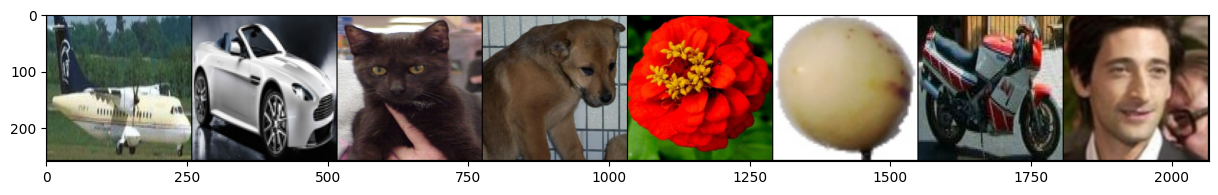

In [ ]:
x = show_batch_image(sample_images)

In [ ]:
class_names = ['Airplane', 'Car', 'Cat', 'Dog', 'Flower', 'Fruit', 'Motorbike', 'Person']
class_position = [0, 1, 2, 3, 4, 5, 6, 7]

In [ ]:
os.makedirs('data/train', exist_ok = True)
os.makedirs('data/test', exist_ok = True)

for classes in class_names:
  os.makedirs(f'data/train/{classes}', exist_ok = True)
  os.makedirs(f'data/test/{classes}', exist_ok = True )

In [ ]:
for i, cls_position in enumerate(class_position):
  image_paths = np.array(glob.glob(f'{train_folders[cls_position]}/*.jpg'))
  class_name = class_names[i]
  print(f'{class_name}:{len(image_paths)}')
  #np.random.shuffle(image_paths)
  train, test = train_test_split(image_paths, random_state = 0, shuffle = True)

  for img in train:
    shutil.copy(img, f'data/train/{class_name}')

  for img in test:
    shutil.copy(img, f'data/test/{class_name}')

Airplane:727
Car:968
Cat:885
Dog:702
Flower:843
Fruit:1000
Motorbike:788
Person:986


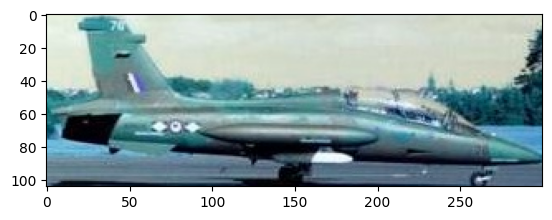

In [ ]:
image=cv2.imread('/content/data/train/Airplane/airplane_0000.jpg')
plt.imshow(image)

In [ ]:
print(image)

[[[232 240 223]
  [232 240 223]
  [233 241 224]
  ...
  [210 217 204]
  [211 218 205]
  [209 216 203]]

 [[230 238 221]
  [231 239 222]
  [232 240 223]
  ...
  [213 220 207]
  [208 215 202]
  [210 217 202]]

 [[228 238 222]
  [229 239 223]
  [229 239 223]
  ...
  [209 214 199]
  [210 217 202]
  [211 219 202]]

 ...

 [[104 128 148]
  [103 127 147]
  [106 128 146]
  ...
  [ 78 100 125]
  [ 79  99 124]
  [ 78  98 123]]

 [[ 90 111 132]
  [ 82 103 124]
  [ 75  94 115]
  ...
  [ 88 109 136]
  [ 89 110 137]
  [ 87 108 135]]

 [[ 96 117 138]
  [ 85 106 127]
  [ 73  92 113]
  ...
  [ 92 113 140]
  [ 94 115 142]
  [ 92 113 140]]]


In [ ]:
print(train.shape)
print(test.shape)

(739,)
(247,)


In [ ]:
mean = [0.4914, 0.4822, 0.4465]
median = [0.2470, 0.2435, 0.2616]

chosen_transforms = {'train': transforms.Compose([
  transforms.RandomResizedCrop(size = 256),
  transforms.ToTensor(),
  transforms.Normalize(mean, median)
]),'test':transforms.Compose([
  transforms.Resize(size = 256),
  transforms.ToTensor(),
  transforms.Normalize(mean, median)
]),}

In [ ]:
data_dir = 'data/'

sample_datasets = {
    x:torchvision.datasets.ImageFolder(os.path.join(data_dir, x), transform = chosen_transforms[x])
    for x in ['train', 'test']
}

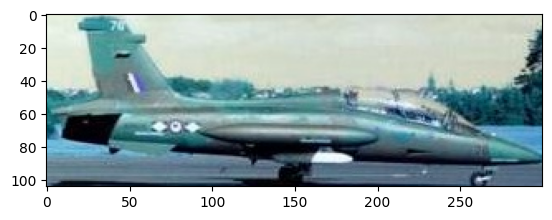

In [ ]:
image=cv2.imread('/content/data/train/Airplane/airplane_0000.jpg')
plt.imshow(image)

In [ ]:
dataloader = {x: DataLoader(sample_datasets[x], batch_size = 6, shuffle=True)
                for x in ['train', 'test'] }

In [ ]:
print(type(dataloader['train']))

<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
dataiter = iter(dataloader['train'])
images, labels = next(dataiter)

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([6, 3, 256, 256])
torch.Size([3, 256, 256])
2


In [ ]:
sample_dataset_sizes = {x: len(sample_datasets[x]) for x in ['train','test']}
true_sample_class_names = sample_datasets['train'].classes

In [ ]:
def imshow(img, title):
  img = img.numpy().transpose(1,2,0)
  mean = np.array([0.4914, 0.4822, 0.4465])
  std = np.array([0.2470, 0.2435, 0.2616])
  img = std*img + mean
  img = np.clip(img, 0, 1)
  plt.figure(figsize=(8,4))
  plt.imshow(img)
  plt.axis('off')
  plt.title(title)
  plt.show()

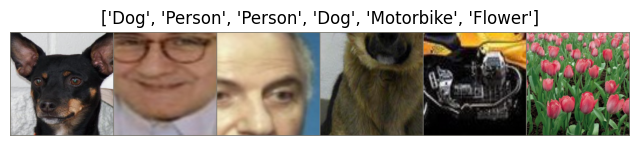

In [ ]:
images, classes = next(iter(dataloader['train']))
imshow(torchvision.utils.make_grid(images), title = [true_sample_class_names[x] for x in classes])

In [ ]:
image_dims = (256, 256)
batch_size = 4

In [ ]:
def imshow_masked(img):
  npimg = img.numpy()
  plt.figure(figsize = (3, 3))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

In [ ]:
class Dataset(torchvision.datasets.ImageFolder):
  def __init__(self, path, image_dims = (256, 256), n_channels = 3):
    super().__init__(path)
    self.n_classes = 8
    self.image_dims = image_dims
    self.n_channels = n_channels
    self.resize = transforms.Resize(image_dims)
    self.to_tensor = transforms.ToTensor()

  def __getitem__(self, index):
    image, label = super().__getitem__(index)

    Y_output = self.resize(image)
    X_input, X_mask = self.Create_Mask(Y_output)
    return self.to_tensor(X_input), self.to_tensor(X_mask), self.to_tensor(Y_output)

  def Create_Mask(self, image):
    mask = np.full((self.image_dims[0], self.image_dims[1], self.n_channels), 255, dtype = np.uint8)

    for _ in range(np.random.randint(1, 10)):
      x1, x2 = np.random.randint(1, self.image_dims[0]), np.random.randint(1, self.image_dims[0])
      y1, y2 = np.random.randint(1, self.image_dims[1]), np.random.randint(1, self.image_dims[1])
      thickness = np.random.randint(10,13)

      cv2.line(mask, (x1, y1), (x2, y2), (1,1,1), thickness)

    image = np.asarray(image)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image, mask

In [ ]:
Trainset = Dataset('data/train', image_dims)
Testset = Dataset('data/test', image_dims)

In [ ]:
type(Trainset)

__main__.Dataset

In [ ]:
Trainloader = torch.utils.data.DataLoader(Trainset, batch_size = batch_size, shuffle = True)
Testloader = torch.utils.data.DataLoader(Testset, batch_size = batch_size, shuffle = False)

In [ ]:
print(batch_size)

4


In [ ]:
print(len(Trainloader))

1293


In [ ]:
Train_dataiter = iter(Trainloader)

In [ ]:
Test_dataiter = iter(Testloader)

In [ ]:
for i in Trainloader:
  X_in=i[0][1]
  X_tr=i[2][1]
  X_mask=i[1][1]
  break

  

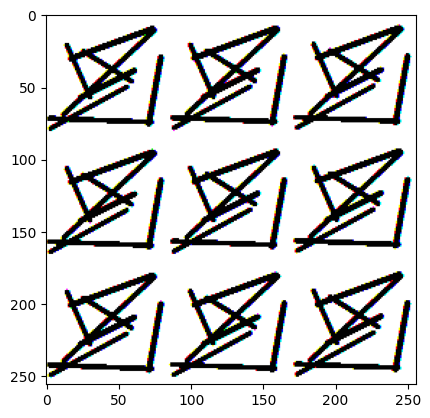

In [ ]:
X_mask=X_mask.reshape(256,256,3)
plt.imshow(X_mask)

In [ ]:

X_in=X_in.reshape(256,256,3)
X_tr=X_tr.reshape(256,256,3)

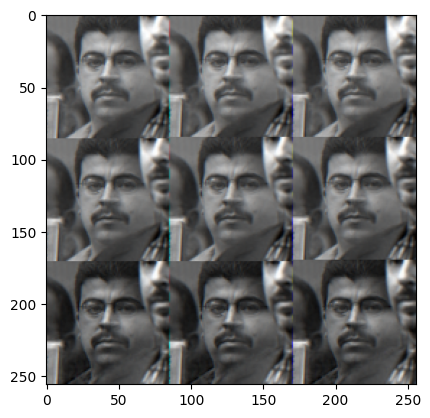

In [ ]:
plt.imshow(X_tr)

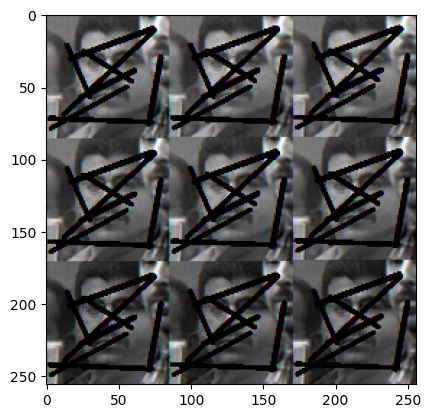

In [ ]:


plt.imshow(X_in)

In [ ]:
X_in, X_mask, Y_out = next(Train_dataiter)
print(X_in.shape, X_mask.shape, Y_out.shape)

torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


Masked Image


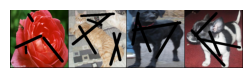

Masking Pattern


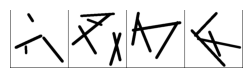

Original Image


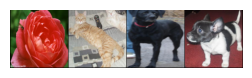

In [ ]:
print('Masked Image')
imshow_masked(torchvision.utils.make_grid(X_in))
print('Masking Pattern')
imshow_masked(torchvision.utils.make_grid(X_mask))
print('Original Image')
imshow_masked(torchvision.utils.make_grid(Y_out))

# **Training**

In [ ]:
layers = 7

In [ ]:
class PartialConvLayer(nn.Module):
  def __init__(self, in_channels, out_channels, bn = True, bias = False, sample = "none-3", activation = "relu"):
    super().__init__()
    self.bn = bn
    self.activation = activation

    if sample == "down-7":
      self.input_conv = nn.Conv2d(in_channels, out_channels, 7, 2, 3, bias = bias)
      self.mask_conv = nn.Conv2d(in_channels, out_channels, 7, 2, 3, bias = False)

    elif sample == "down-5":
      self.input_conv = nn.Conv2d(in_channels, out_channels, 5, 2, 2, bias = bias)
      self.mask_conv = nn.Conv2d(in_channels, out_channels, 5, 2, 2, bias = False)

    elif sample == "down-3":
      self.input_conv = nn.Conv2d(in_channels, out_channels, 3, 2, 1, bias = bias)
      self.mask_conv = nn.Conv2d(in_channels, out_channels, 3, 2, 1, bias = False)
    
    else:
      self.input_conv = nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=bias)
      self.mask_conv = nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False)
      
    nn.init.constant_(self.mask_conv.weight, 1.0)
    nn.init.kaiming_normal_(self.input_conv.weight, a = 0, mode = "fan_in")

    for param in self.mask_conv.parameters():
      param.requires_grad = False

    if bn:
      self.batch_normalization = nn.BatchNorm2d(out_channels)

    if activation == "relu":
      self.activation = nn.ReLU()
    elif activation == "leaky_relu":
      self.activation == nn.LeakyReLU(negative_slope = 0.2)

  def forward(self, input_x, mask):
    output = self.input_conv(input_x * mask)
    with torch.no_grad():
      output_mask = self.mask_conv(mask)
    
    if self.input_conv.bias is not None:
      output_bias = self.input_conv.bias.view(1, -1, 1, 1).expand_as(output)
    else:
      output_bias = torch.zeros_like(output)

    mask_is_zero = (output_mask == 0)
    mask_sum = output_mask.masked_fill_(mask_is_zero, 1.0)

    output = (output - output_bias) / mask_sum + output_bias
    output = output.masked_fill(mask_is_zero, 0.0)

    new_mask = torch.ones_like(output)
    new_mask = new_mask.masked_fill_(mask_is_zero, 0.0)

    if self.bn:
      output = self.batch_normalization(output)
    #if hasattr(self, 'activation'):
      #output = self.activation(output)

    return output, new_mask

class PartialConvUNet(nn.Module):
  def __init__(self, input_size = 256, layer = 7):
    if 2**(layers + 1) != input_size:
      raise AssertionError

    super().__init__()
    self.freeze_enc_bn = False
    self.layers = layers

    self.encoder_1 = PartialConvLayer(3, 64, bn=False, sample="down-7")
    self.encoder_2 = PartialConvLayer(64, 128, sample="down-5")
    self.encoder_3 = PartialConvLayer(128, 256, sample="down-3")
    self.encoder_4 = PartialConvLayer(256, 512, sample="down-3")

    for i in range(5, layers + 1):
      name = "encoder_{:d}".format(i)
      setattr(self, name, PartialConvLayer(512, 512, sample="down-3"))
   
    for i in range(5, layers + 1):
      name = "decoder_{:d}".format(i)
      setattr(self, name, PartialConvLayer(512 + 512, 512, activation="leaky_relu"))
   
    self.decoder_4 = PartialConvLayer(512 + 256, 256, activation="leaky_relu")
    self.decoder_3 = PartialConvLayer(256 + 128, 128, activation="leaky_relu")
    self.decoder_2 = PartialConvLayer(128 + 64, 64, activation="leaky_relu")
    self.decoder_1 = PartialConvLayer(64 + 3, 3, bn=False, activation="", bias=True)

  def forward(self, input_x, mask):
    encoder_dict = {}
    mask_dict = {}
    key_prev = "h_0"
    encoder_dict[key_prev], mask_dict[key_prev] = input_x, mask

    for i in range(1, self.layers + 1):
      encoder_key = "encoder_{:d}".format(i)
      key = "h_{:d}".format(i)
      encoder_dict[key], mask_dict[key] = getattr(self, encoder_key)(encoder_dict[key_prev], mask_dict[key_prev])
      key_prev = key

    out_key = "h_{:d}".format(self.layers)
    out_data, out_mask = encoder_dict[out_key], mask_dict[out_key]

    for i in range(self.layers, 0, -1):
      encoder_key = "h_{:d}".format(i - 1)
      decoder_key = "decoder_{:d}".format(i)
      out_data = F.interpolate(out_data, scale_factor=2)
      out_mask = F.interpolate(out_mask, scale_factor=2)
      out_data = torch.cat([out_data, encoder_dict[encoder_key]], dim=1)
      out_mask = torch.cat([out_mask, mask_dict[encoder_key]], dim=1)
      out_data, out_mask = getattr(self, decoder_key)(out_data, out_mask)
    return out_data

  def train(self, mode=True):
    super().train(mode)
    if self.freeze_enc_bn:
      for name, module in self.named_modules():
        if isinstance(module, nn.BatchNorm2d) and "enc" in name:
          module.eval()

In [ ]:
def Dice_coeff(dataloader):
  for (X_input, X_mask, Y_output) in dataloader:
    X_input, X_mask, Y_output = X_input.to(device), X_mask.to(device), Y_output.to(device)
    outputs = model(X_input, X_mask)
    eps = 1e-15
    outputs = outputs.view(-1)
    Y_output = Y_output.view(-1)
    intersection = (outputs * Y_output).sum()
    sum = (outputs.sum() + Y_output.sum())
  return (2*(intersection) / (sum + eps))

In [ ]:
model = PartialConvUNet().to(device)
model = model.to(device)

In [ ]:
loss_fn = nn.MSELoss()
opt = optim.Adam(model.parameters())

In [ ]:
loss_epoch_arr = []
max_epochs = 10

min_loss = 1000

n_iters = np.ceil(50000/batch_size)
for epoch in range(max_epochs):
    model.train()                               
    for i, (X_input, X_mask, Y_output) in enumerate(Trainloader, 0):

        X_input, X_mask, Y_output = X_input.to(device), X_mask.to(device), Y_output.to(device)

        opt.zero_grad()

        outputs = model(X_input, X_mask)
        loss = loss_fn(Y_output, outputs)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(model.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.002f' % (i, n_iters, loss.item()))
            
        del X_input, X_mask, Y_output
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
plt.plot(loss_epoch_arr)
plt.show()

Min loss 0.36
Iteration: 0/12500, Loss: 0.36
Min loss 0.23
Min loss 0.21
Min loss 0.21
Min loss 0.19
Min loss 0.19
Min loss 0.17
Min loss 0.16
Min loss 0.14
Min loss 0.14
Min loss 0.08
Iteration: 100/12500, Loss: 0.14


In [ ]:
model.load_state_dict(best_model)

# **Testing**

In [ ]:
for j in Trainloader:
  sample_inputs, sample_masks, sample_truths = j
  sample_inputs, sample_masks = sample_inputs.cuda(), sample_masks.cuda()

  model.eval()
  with torch.no_grad():
      sample_preds = model(sample_inputs, sample_masks)

  fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

  sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
  for i in range(4):
      axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
      axs[i][1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
      axs[i][2].imshow(np.transpose(sample_inputs[i],(1, 2, 0)))
      axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))
  break    

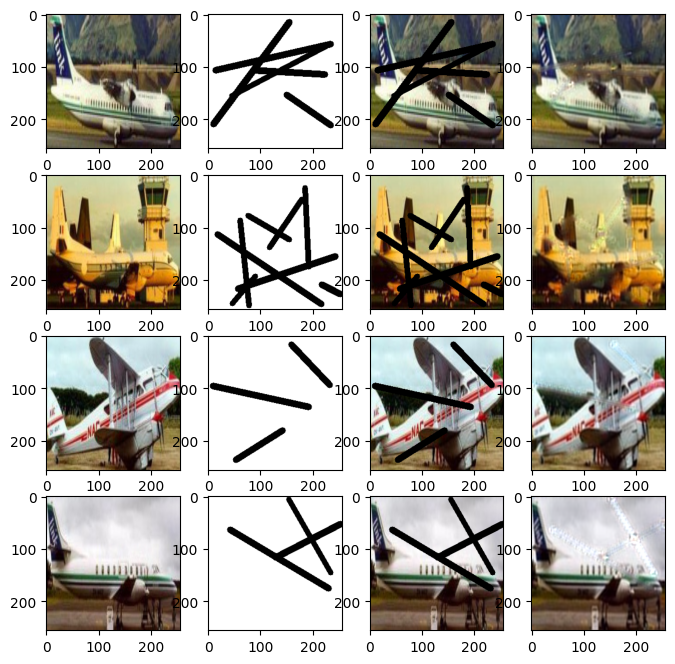

In [ ]:
for j in Testloader:
  sample_inputs, sample_masks, sample_truths = j
  sample_inputs, sample_masks = sample_inputs.cuda(), sample_masks.cuda()

  model.eval()
  with torch.no_grad():
      sample_preds = model(sample_inputs, sample_masks)

  fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

  sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
  for i in range(4):
      axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
      axs[i][1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
      axs[i][2].imshow(np.transpose(sample_inputs[i],(1, 2, 0)))
      axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))
  break    

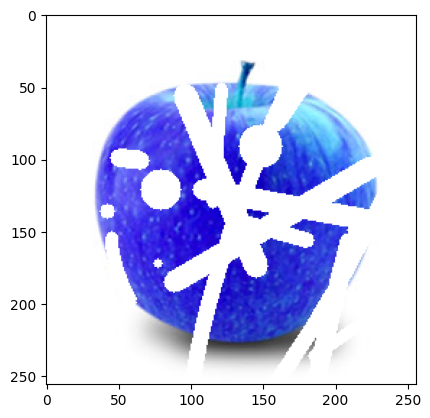

In [ ]:
x_input=cv2.imread('/content/10_inpainted.png')
x_mask=cv2.imread('/content/10_mask.png')

plt.imshow(x_input)

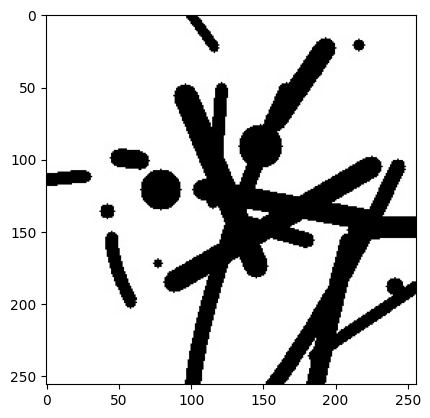

In [ ]:
plt.imshow(x_mask)

In [ ]:
mean = [0.4914, 0.4822, 0.4465]
median = [0.2470, 0.2435, 0.2616]

x_input=(x_input-mean)/median
x_mask=

TypeError: ignored

torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])


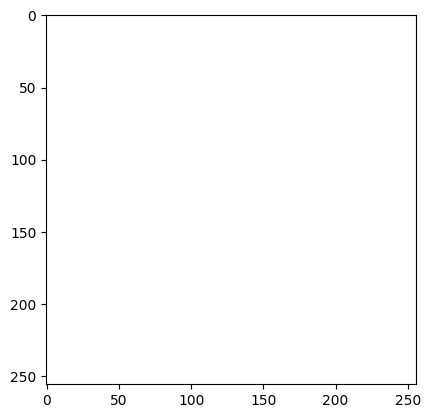

In [ ]:
x_input,x_mask=torch.from_numpy(x_input),torch.from_numpy(x_mask)
with torch.no_grad():
  x_input,x_mask= x_input.float(),x_mask.float()

  x_input,x_mask=x_input.reshape(1,3,256,256),x_mask.reshape(1,3,256,256)
  print(x_input.shape)
  x_input,x_mask=x_input.to(device),x_mask.to(device)
  pred=model(x_input,x_mask)
  pred=pred.reshape(3,256,256)
  print(pred.shape)
  plt.imshow((np.transpose(pred.cpu())))


# **Evaluation**

In [ ]:
def load_image(image_path, resize = True):  
  img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)
  
  return img

In [ ]:
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

In [ ]:
def masking(image):

  Y_output = transforms.Resize((256, 256))

  mask = np.full((256, 256, 3), 255, dtype = np.uint8)

  for _ in range(np.random.randint(1, 5)):
    x1, x2 = np.random.randint(1, 256), np.random.randint(1, 256)
    y1, y2 = np.random.randint(1, 256), np.random.randint(1, 256)
    thickness = np.random.randint(2,10)

    cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)

  image = np.asarray(image)
  masked_image = cv2.bitwise_and(image, mask)
  masked_image, mask
  
  X_input, X_mask = masked_image, mask
  X_input = Image.fromarray(X_input)
  X_mask = Image.fromarray(X_mask)
  return X_input, X_mask

In [ ]:
def Inpaint(masked_image, mask):
  mean = np.array([0.4914, 0.4822, 0.4465])
  std = np.array([0.2470, 0.2435, 0.2616])
  #mean = np.array([0.5, 0.5, 0.5])
  #std = np.array([0.5, 0.5, 0.5])
  masked_image = torch.from_numpy(masked_image)
  masked_image = torch.as_tensor(masked_image, dtype=torch.float64)
  masked_image = transforms.Normalize(mean, std)(masked_image)
  mask = torch.from_numpy(mask)
  mask = torch.as_tensor(mask, dtype=torch.float64)
  mask= transforms.Normalize(mean, std)(mask)
  masked_image, mask = masked_image.cuda(), mask.cuda()
  model.eval()
  with torch.no_grad():
    predicted_image = model(masked_image[None].float().to(device), mask[None].float().to(device))
    predicted_image = predicted_image.cpu()
    print(predicted_image.shape)
    pred = predicted_image.squeeze()
    print(pred.shape)
    pred1 = pred.numpy()
    print(pred1.shape)
    pred2 = np.transpose(pred1, (1, 2, 0))
    pred3 = std*pred2 + mean
    plt.imshow((pred3/2).astype(np.uint16))

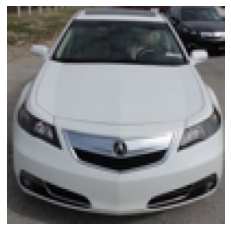

In [ ]:
show_image('toyota.jpg')

In [ ]:
sample_image = load_image('toyota.jpg')
tran = transforms.ToPILImage()
sample_image = tran(sample_image)

In [ ]:
X_input, X_mask = masking(sample_image)

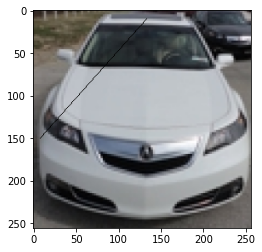

In [ ]:
X_input = np.asarray(X_input)
plt.imshow(X_input)
plt.show()

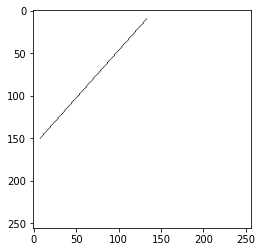

In [ ]:
X_mask = np.asarray(X_mask)
plt.imshow(X_mask)
plt.show()

In [ ]:
X_input1 = np.transpose(X_input,(2, 0, 1))
print(X_input1.shape)

(3, 256, 256)


In [ ]:
X_mask1 = np.transpose(X_mask,(2, 0, 1))
print(X_mask1.shape)

(3, 256, 256)


torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])
(3, 256, 256)


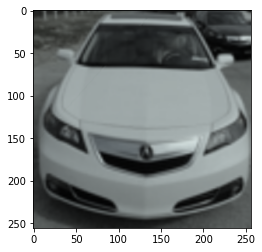

In [ ]:
Inpaint(X_input1, X_mask1)

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


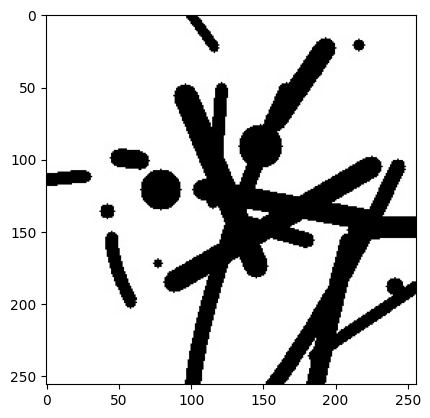

In [ ]:
import cv2
import matplotlib.pyplot as plt
image=cv2.imread('/content/10_mask.png')
print(image)
plt.imshow(image)

In [ ]:
import numpy as np
a=np.unique(image)
print(a)

[  0   1   2   3   4   5   6   7 248 249 250 251 252 253 254 255]
